<a href="https://colab.research.google.com/github/mindadeepam/CIFAR-10-Object-Recognition-in-Images/blob/main/cifr10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


## load dataset

In [5]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()

In [6]:
xtrain.shape, ytrain.shape

((50000, 32, 32, 3), (50000, 1))

In [7]:
np.unique(ytrain, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [8]:
classes =	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
def plot_sample(i):
  plt.imshow(xtrain[i])
  plt.xlabel(classes[ytrain[i]])

## utils

In [10]:
# transformer = Normalizer().fit(xtrain)
def normalize(x):
  return x/255

In [59]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  plt.figure(figsize=(15,15))
  plt.suptitle(f'Model')
  colors = ["#c52c1b", "#b753ea", "#13dd13", "#00ccff"]

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[n], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[n], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([plt.ylim()[0]-.1, 2])
    elif metric == 'auc' or metric == 'prc':
      plt.ylim([plt.ylim()[0]-.1, 1])
    else:
      plt.ylim([plt.ylim()[0]-.1, plt.ylim()[1]+.1])

    plt.legend();
    plt.savefig(f'Model_train_metrics.png') 

## preprocessing

In [11]:
xtrain[5:10,:,:,:].shape

(5, 32, 32, 3)

In [12]:
xtrain = normalize(xtrain)
xtest = normalize(xtest)

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))

AUTOTUNE = tf.data.AUTOTUNE
batch_size=32
train_ds = train_ds.shuffle(buffer_size=len(train_ds))\
              .batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


In [14]:
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest))
AUTOTUNE = tf.data.AUTOTUNE
batch_size=32
test_ds = test_ds.shuffle(buffer_size=len(test_ds))\
              .batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## ANN model

In [28]:
base_model = tf.keras.Sequential()
base_model.add(Flatten(input_shape=(32,32,3)))
base_model.add(Dense(1024, activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(256, activation="relu"))
base_model.add(Dropout(0.5))
base_model.add(Dense(64, activation="relu"))
base_model.add(Dense(10, activation='softmax'))

In [29]:
base_model.compile(metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
base_model.summary()

### untrained model - baseline

In [21]:
ypred=base_model.predict(xtrain)

In [22]:
predictions = np.array([np.argmax(element) for element in ypred])
predictions = predictions.reshape(-1,1)
assert ytrain.shape == predictions.shape

In [23]:
print(classification_report(ytrain, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5000
           1       0.00      0.00      0.00      5000
           2       0.00      0.00      0.00      5000
           3       0.00      0.00      0.00      5000
           4       0.10      1.00      0.18      5000
           5       0.00      0.00      0.00      5000
           6       0.00      0.00      0.00      5000
           7       0.00      0.00      0.00      5000
           8       0.00      0.00      0.00      5000
           9       0.00      0.00      0.00      5000

    accuracy                           0.10     50000
   macro avg       0.01      0.10      0.02     50000
weighted avg       0.01      0.10      0.02     50000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ann model performance

In [31]:
histories = {}

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = base_model.fit(train_ds, validation_data=test_ds, epochs=50, callback=[stop_early])
histories['1e-3'] = history


In [42]:
## e-2 too high LR - No learning
history = base_model.fit(train_ds, epochs=50)
histories['1e-2'] = history

In [64]:
ypred=base_model.predict(xtrain)
predictions = np.array([np.argmax(element) for element in ypred])
predictions = predictions.reshape(-1,1)
ann_accuracy = base_model.evaluate(train_ds)

1563/1563 [==============================] - 6s 3ms/step - loss: 1.2390 - accuracy: 0.5664


## CNN model

In [74]:
def create_cnn():
  cnn_model = tf.keras.Sequential()
  cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'))
  cnn_model.add(MaxPool2D((2, 2)))
  cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
  cnn_model.add(MaxPool2D((2, 2)))
  cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
  cnn_model.add(MaxPool2D((2, 2)))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(Dense(32, activation='relu'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(Dense(10, activation='softmax'))
  # cnn_model.add(MaxPool2D((2, 2)))

  cnn_model.compile(metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))
  
  return cnn_model

In [ ]:
## callbacks
checkpoint_filepath = f'cnn_checkpoint/model_checkpoint'  
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

## train model
cnn_model = create_cnn()
history = cnn_model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[stop_early,model_checkpoint])

In [76]:
## load best model from checkpoint and evaluate against test data
loaded_cnn = create_cnn()
loaded_cnn.load_weights(checkpoint_filepath)


cnn_y = loaded_cnn.predict(xtrain)
cnn_predictions = np.array([np.argmax(element) for element in cnn_y])
cnn_predictions = predictions.reshape(-1,1)
cnn_accuracy = loaded_cnn.evaluate(train_ds)

1563/1563 [==============================] - 6s 3ms/step - loss: 0.4699 - accuracy: 0.8405


In [77]:
cnn_histories = {}
cnn_histories['1e-4'] = history

In [ ]:
print(classification_report(ytrain, cnn_predictions))

## plot metrics

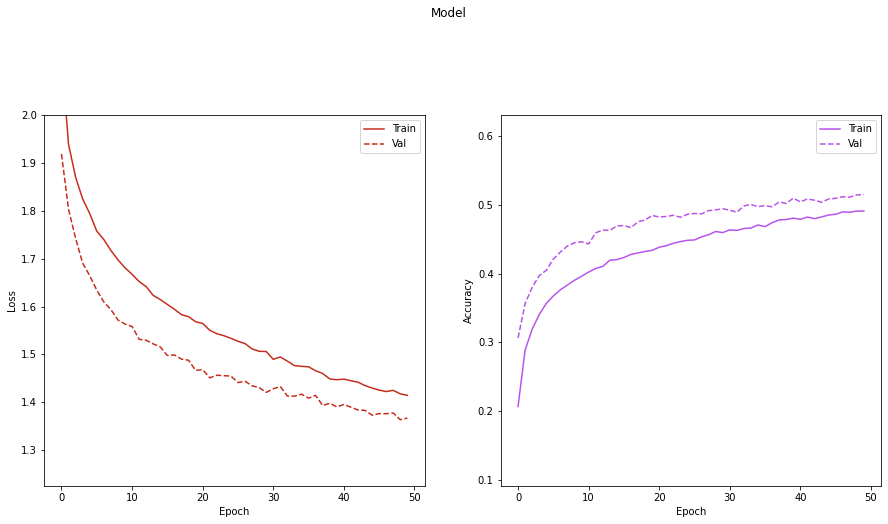

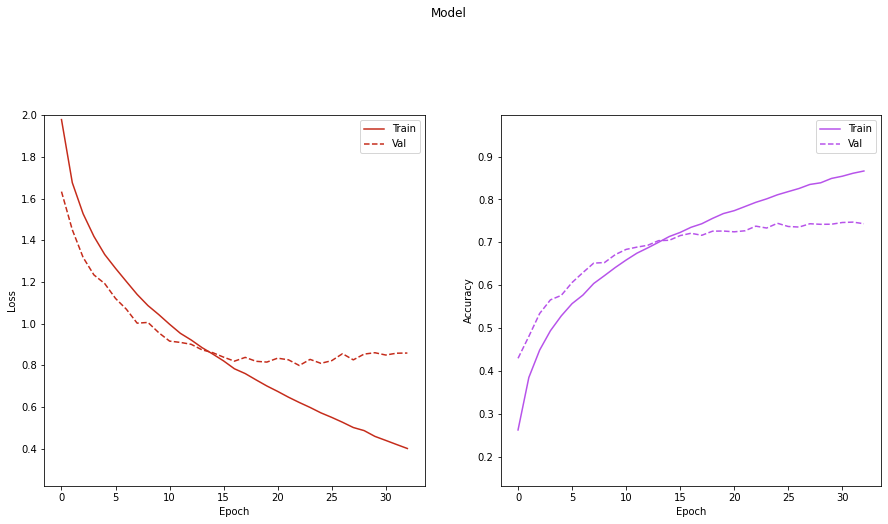

In [79]:
plot_metrics(histories['1e-3'])
plot_metrics(cnn_histories['1e-4'])